# Advanced Plotting with Python

#### Learning how to create publication-ready plots takes practice, requires constructive feedback and frequent revison of code

So the following two examples are from my own work, one from when I started my PhD using NCAR Command Language and the other from a more recent project using Python

| NCL Example                  | Python Example                  |
|:-----------------------------:|:-----------------------------:|
| <img src='first_topo_example.png'> | <img src='recent_topo_example.png' width = 600, height = 300> |

#### CMS Blog Posts on Plotting

- Plotting basics: https://climate-cms.org/2018/04/19/plotting-basics.html
- Subplots: https://climate-cms.org/2018/04/27/subplots.html
- Improving Maps with Cartopy: https://climate-cms.org/2018/04/19/cartopy-maps.html
- Xarray Plot Types: https://climate-cms.org/2018/04/27/xarray-plot-types.html
- Line Plots with Xarray: https://climate-cms.org/2018/09/28/line-plots-with-xarray.html
- Animating Fields with Python: https://climate-cms.org/2019/09/03/python-animation.html
- Wrapping Gridded Data Around the World: https://climate-cms.org/2020/09/22/wrapping-pcolormesh.html
- Plots with a Split Y-axis: https://climate-cms.org/2020/09/23/split-yaxis.html
- Visualisation with the Shiny App (An R example!) - https://climate-cms.org/visualisation,/r,/shiny/2018/08/21/visualisation-in-shiny-app.html
- Generating Print Quality Plots in R: https://climate-cms.org/plots,/r,/rstudio/2019/03/06/generating-print-quality-plots.html


#### Useful Links for Data Visualization - Polish My Plot Resources

- Python Graph Gallery: https://python-graph-gallery.com/
- How to Make Beautiful Plots in Python: http://www.randalolson.com/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/
- Sample Plots in Matplotlib: https://matplotlib.org/3.1.1/tutorials/introductory/sample_plots.html
- Top 50 matplotlib Visualizations: https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/
- Statistical Data Visualization with Seaborn: https://seaborn.pydata.org/



#### Best Practice Tips

- Be mindful of those who are colorblind - Colorbrewer can help with that https://colorbrewer2.org/#type=diverging&scheme=BrBG&n=3
- Be mindful of how people may interpret colors (i.e. $\color{blue}{\text{cold}}$, $\color{red}{\text{hot}}$, $\color{brown}{\text{dry}}$, $\color{green}{\text{wet}}$)
- If using diverging color schemes ask yourself what does 'white' mean as people often interpret that as zero or no-data
- For global contour maps if you care about the land split the Pacific Ocean if interested in ocean at longitude zero
- Less is more, for multi-panel plots consider the following to simplify the overall figure:
    - set the same axis limits so that you only require labels and tick marks on the outer panels
    - reduce the white space between panels
    - consider using the same colorscheme for contour maps and only have one colorbar
    - always annotate panels alphabetically going from left to right, top to bottom - preferred by journals
    - label columns and rows rather than individual panels

### Splitting Global Maps Example

| Preferred for Land Foci                 | Preferred for Ocean Foci                  |
|:-----------------------------:|:-----------------------------:|
| <img src='land_example.png' width = 500, height = 300> | <img src='ocean_example.png' width = 500, height = 300> |

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_map(lon,figname):
    plt.rcParams['savefig.dpi']=100
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=lon))
    ax.coastlines()
    plt.savefig(figname)

plot_map(0,'land_example.png')
plot_map(180,'ocean_example.png')

### Layering Example

This is using WRF outputs from a research project of mine to run <1km resolution simulations with a n urban parameterization. I have post-processed using a different notebook available in: https://github.com/annettehirsch/hirsch_wrf-urban

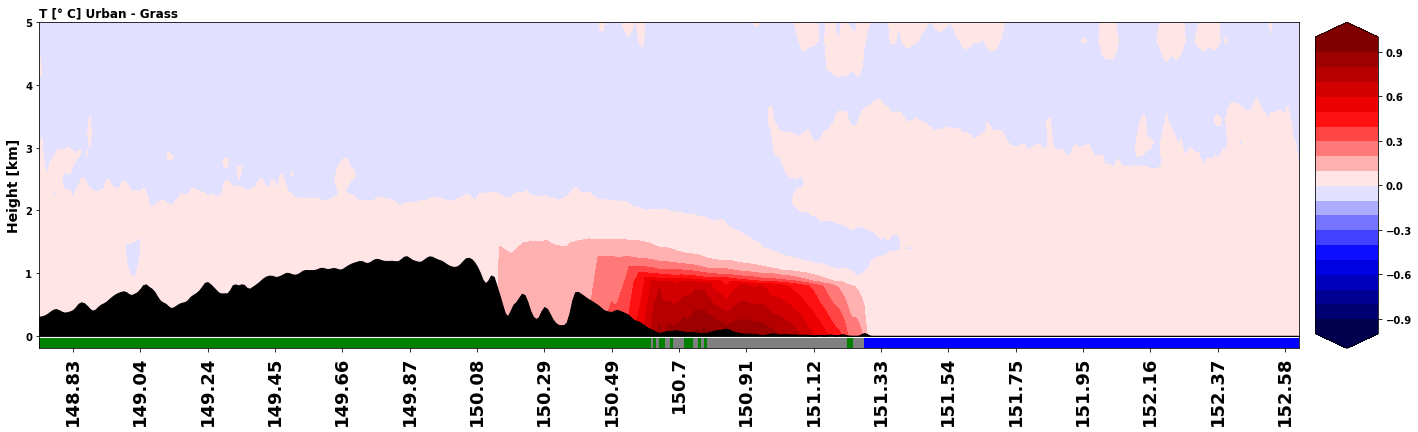

In [6]:
plot_contrast(T,Z,lon,hgt,luma)

So how did we produce this figure?

First import packages

In [1]:
import numpy as np
import netCDF4 as nc

Read in the invariant fields land use, longitude and terrain height at the latitude to which the data has been extracted. 

In [2]:
i0 = 174
f = nc.Dataset('sample_data/geo_em.d02_sample.nc')
lu = f.variables['LU_INDEX'][0,i0,:] # Dominant landuse per grid cell
lon = f.variables['XLONG_M'][0,i0,:] # Longitude values along the line of latitude
hgt = f.variables['HGT_M'][0,i0,:] / 1000. # Terrain height in km along the line of latitude
f.close()

From the Land Use info, create an array to distinguish between vegetation, ocean and urban

In [3]:
luma = [None] * len(lu)
for ll in range(len(luma)):
    if lu[ll] in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
        luma[ll] = 'l'
    elif lu[ll] == 17:
        luma[ll] = 'o'
    else:
        luma[ll] = 'u'

Reading previously extracted data

In [4]:
file = nc.Dataset('sample_data/wrfout_d02_minus_d03_sample.nc','r')
T = file.variables['T'][:,:] # Temperature different urban minus non-urban
Z = file.variables['lev'][:]
file.close()

Define the plotting function

In [5]:
def plot_contrast(T,Z,lon1d,hgt,luma,mxmn=1.0):

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.colors import BoundaryNorm
    from matplotlib.ticker import MaxNLocator
    plt.rcParams["font.weight"] = "bold"
    
    nrow = 1
    ncol = 2
    nbins = 20
    wratios = np.repeat(1.,ncol)
    wratios[-1] = 0.05   
    gs = mpl.gridspec.GridSpec(nrows=nrow,ncols=ncol, width_ratios=wratios, wspace=0.025)
    fig = plt.figure(figsize=(24.0,6.0))
    
    # Make axes
    ax = fig.add_subplot(gs[0,0])
    
    # Colour bar axes (':' as the colour bars cover multiple rows)
    # Use a new subplot so we can control the spacing better
    cgs = mpl.gridspec.GridSpecFromSubplotSpec(nrows=nrow,ncols=1, subplot_spec=gs[:,1], wspace=0.1)
    cax = plt.subplot(cgs[0,0])
    
    # Convert lon1d and Z into 2D arrays for including topography
    lons = np.repeat(lon1d[np.newaxis],len(Z),axis=0)
    Z2d = np.empty(lons.shape,np.float64)
    for ll in range(len(lon1d)):
        for zz in range(len(Z)):
            if zz == 0:
                Z2d[0,ll] = hgt[ll]# Z[zz] - hgt[ll]
            else:
                Z2d[zz,ll] = Z[zz] + hgt[ll]
      
    
    # Define the levels for the contour lines
    levels = MaxNLocator(nbins=nbins).tick_values(-mxmn,mxmn)
    norm = BoundaryNorm(levels,ncolors=plt.get_cmap('seismic').N, clip=True)
        
    # Plot the data
    cm = ax.contourf(lons,Z2d,T, vmin=-mxmn,vmax=mxmn,cmap='seismic', levels=levels, norm=norm, extend='both')

    # Label the Y-axis and add a title
    ax.set_ylabel('Height [km]', fontweight = 'bold',fontsize=14)
    ax.set_title('T [\xb0 C] Urban - Grass', fontweight='bold',loc='left')
    
    # Add sillouette of topography - to be checked!
    ax.fill_between(lon1d, hgt, 0, interpolate=True, color='black')
    
    # Add land use type
    lucol = { 'l' : 'green',
            'o' : 'blue',
            'u' : 'grey'}
    c = [lucol[val] for val in luma]
    ax.scatter(lon1d,np.zeros(len(lon1d))-0.075,c=c,marker='s')
    ax.scatter(lon1d,np.zeros(len(lon1d))-0.175,c=c,marker='s')
    
    # Amend x-axis
    ax.set_xticks(lon1d[12::24])
    ax.set_xticklabels(np.round(lon1d[12::24],2),rotation=90,fontsize=18)

    # Amend y-axis
    ax.set_ylim(-0.2,5)
    
    # All the colorbar on the separate subplot
    plt.colorbar(cm, cax)
    
    # Uncomment the following lines to save the figure
#    plt.savefig('test.png')
#    plt.close(fig)

### Adding Hatching/Stippling Example

This example plots mean estimates of 4 heatwave diagnostics calculated over the period 1950 to 2014 for the Berkeley Earth observational data and the CMIP6 ensemble mean bias. Hatching where there is atleast 80% model agreement over the bias plot panels.

For hatching styles see: https://matplotlib.org/devdocs/gallery/shapes_and_collections/hatch_style_reference.html

Load packages

In [1]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import regionmask

Read in some data - in this example we use some previously calculated heatwave diagnostics from Berkeley Earth and the CMIP6 ensemble mean bias (model minus Berkeley Earth).

Note that for the CMIP6 bias we also calculated the model agreement and stored this in a multi-dimension array where 0 = <80% models agree on the sign and 1 = atleast 80% of models agree on the sign.

In [2]:
file = nc.Dataset('sample_data/CMIP6_heatwave_sample.nc','r')
lat1d = file.variables['lat'][30:] # The latitudes excluding Antarctica
lon1d = file.variables['lon'][:]
BEmean = file.variables['BEmean'][:,30:,:]
bias = file.variables['bias'][:,30:,:]
sig = file.variables['biassign'][:,30:,:]

Define the common grid for the models to regrid too

In [3]:
ds = xr.Dataset({'lat': (['lat'], lat1d),'lon': (['lon'], lon1d)})

Use regionmask to get a landsea mask (1 = land) at the grid resolution defined above

In [4]:
land_110 = regionmask.defined_regions.natural_earth.land_110
land_mask = land_110.mask(ds)
# Repeat the landmask to the same shape as the data we want to plot:
lm = np.repeat(land_mask.values[np.newaxis,...],4,axis=0) 

Apply this mask to the data

In [5]:
maBEmean = np.ma.masked_array(BEmean,lm!=0).filled(np.nan)
mabias = np.ma.masked_array(bias,lm!=0).filled(np.nan)
masig = np.ma.masked_array(sig,lm!=0).filled(np.nan)
masig2 = np.where(masig<=-1,1,masig)

Define the plot function

In [6]:
def plot_ensemble_contour(lat1d,lon1d,odata,mdata,sig,vlabel,omn,omx,mnmx,figurename):

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.colors import BoundaryNorm
    from matplotlib.ticker import MaxNLocator
    import cartopy.crs as ccrs
    from string import ascii_lowercase
    
    # Figure formatting
    plt.rcParams['savefig.dpi']=500
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    
    # Set up projection
    plotcrs = ccrs.PlateCarree(central_longitude=0)
    lon2d, lat2d = np.meshgrid(lon1d, lat1d)
    
    nrow = 4
    ncol = 2
    nvar = odata.shape[0]
    
    fig, ax = plt.subplots(nrows=nrow,ncols=ncol, figsize=((5.5*ncol),2*nrow), 
            subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)}) # Specifies the projection for the plots

    # Define the colormaps
    ocmap = plt.get_cmap('YlOrRd')
    cmap = plt.get_cmap('seismic')
    
    # Loop through the diagnostics
    vind = 0
    for vv in range(nvar):       
        
        # Plot the observational data
        cm1 = ax[vv,0].contourf(lon2d,lat2d,odata[vv,:,:],vmin=omn[vv],vmax=omx[vv],cmap=ocmap, 
                levels=MaxNLocator(nbins=10).tick_values(omn[vv],omx[vv]), 
                norm=BoundaryNorm(MaxNLocator(nbins=10).tick_values(omn[vv],omx[vv]), ncolors=ocmap.N, clip=True),
                extend='both',transform=ccrs.PlateCarree())
        
        # Plot the model data
        cm2 = ax[vv,1].contourf(lon2d,lat2d,mdata[vv,:,:],vmin=-mnmx[vv],vmax=mnmx[vv],cmap=cmap, 
                levels=MaxNLocator(nbins=20).tick_values(-mnmx[vv],mnmx[vv]), 
                norm=BoundaryNorm(MaxNLocator(nbins=20).tick_values(-mnmx[vv],mnmx[vv]), ncolors=cmap.N, clip=True), 
                extend='both',transform=ccrs.PlateCarree())

        # Add the stippling to the panels in the second column
        ax[vv,1].contourf(lon2d,lat2d,sig[vv,:,:],1,colors="none",hatches=[None,'xx'],
                extend='lower',transform=ccrs.PlateCarree())
        
        # Add the coastlines
        ax[vv,0].coastlines()
        ax[vv,1].coastlines()

        ## Adding panel subplot alphabet label
        ax[vv,0].text(0.016,0.035,'(%s)' %(ascii_lowercase[vind]),
                horizontalalignment='left',verticalalignment='bottom',
                transform = ax[vv,0].transAxes,fontweight='bold', fontsize=12)
        vind+=1
        ax[vv,1].text(0.016,0.035,'(%s)' %(ascii_lowercase[vind]),
                horizontalalignment='left',verticalalignment='bottom',
                transform = ax[vv,1].transAxes,fontweight='bold', fontsize=12)
        vind+=1
        
        ## Adding row label
        ax[vv,0].text(-0.05,0.5,vlabel[vv],horizontalalignment='center',verticalalignment='center',
                transform = ax[vv,0].transAxes,rotation=90.,fontweight='bold', fontsize=10)
        
        # Add the colorbars
        plt.colorbar(cm1, ax=ax[vv,0])
        plt.colorbar(cm2, ax=ax[vv,1])
       
        # Add titles for each column   
        if vv == 0:
            ax[0,0].set_title('Berkeley Earth', fontweight='bold', fontsize=12)
            ax[0,1].set_title('CMIP6 Ensemble - Berkeley Earth', fontweight='bold', fontsize=12)


    # Adjust the white space between subplots
    fig.subplots_adjust(wspace=0.0001, hspace=0.025)

    # Uncomment the following lines to save the figure
#    plt.savefig(figurename, bbox_inches='tight')
#    plt.close(fig)


Plot the data

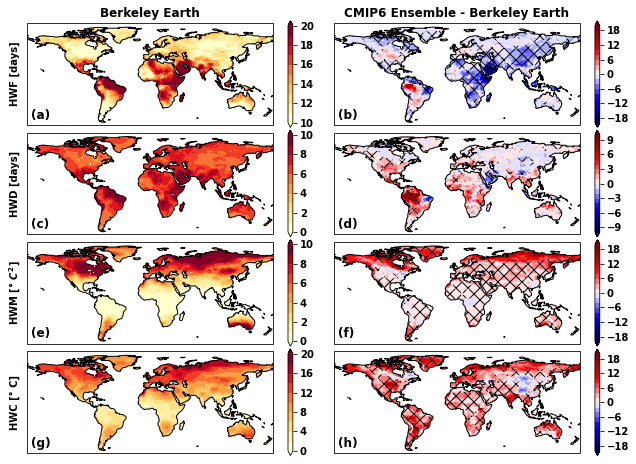

In [7]:
omn = [10,0,0,0] # minima for the observed mean
omx = [20,10,10,20] # maxima for the observed mean
varlim = [20,10,20,20] # bias limits
vlabels = ['HWF [days]','HWD [days]','HWM [\xb0 $C^{2}$]','HWC [\xb0 C]']
plot_ensemble_contour(lat1d,lon1d,maBEmean,mabias,masig2,vlabels,omn,omx,varlim,'figname.png')

### Other useful things to know

##### How to move your legend to somewhere outside the panel

You need to provide `xpos` and `ypos` values that determine where to put your legend relative to the figure `ax` of interest.

`xpos` = horizontal position relative your subplot axes where 0 = on the left, 0.5 = middle, 1.0 on the right

`ypos` = vertical position relative to your subplot axes where values < 0 put the legend below the x-axis

You can also specify if you want the legend to have columns using the optional `ncol` keyword. This best when placing the legend below the plot. 

Plot your data as per usual giving each unique dataset a label and when you call the legend:

`legend = ax[-1].legend(loc='upper center', bbox_to_anchor=(xpos,ypos), ncol=ncols, fontsize=12)`

##### Combining colormaps to create your own

The following is a great resource for available colormaps in python: https://matplotlib.org/stable/tutorials/colors/colormaps.html

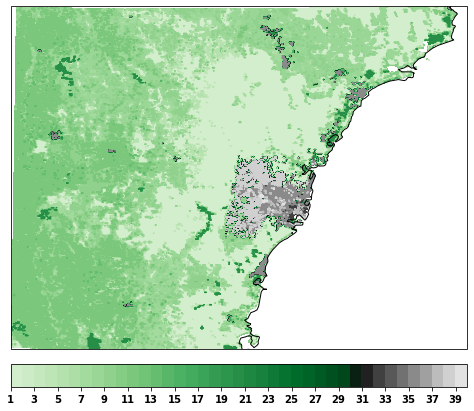

In [1]:
# Load packages
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
import cartopy.crs as ccrs

# Read data
f = nc.Dataset('sample_data/geo_em.d02_sample.nc')
lu = f.variables['LU_INDEX'][0,:,:]
lat2d = f.variables['XLAT_M'][0,:,:]
lontmp = f.variables['XLONG_M'][0,:,:]
lon2d = np.where(lontmp<0.0,lontmp+360,lontmp)
clon = f.getncattr('CEN_LON')
nlu = f.getncattr('NUM_LAND_CAT')
iswater = f.getncattr('ISWATER')
f.close()
    
# Mask the water bodies
luma = np.ma.masked_where(lu == iswater, lu)

# Figure formatting
plt.rcParams['savefig.dpi']=250
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
    
# Set up projection
plotcrs = ccrs.PlateCarree(central_longitude=clon)
    
# Specify the figure axes
gs = mpl.gridspec.GridSpec(nrows=1,ncols=1)
fig = plt.figure(figsize=(10.0,7.0))
ax = fig.add_subplot(gs[0,0],projection=plotcrs)

# Specify the colormap with 1-30 green hues and 30-40 as grey hues
colors1 = plt.cm.Greens(np.linspace(0.2,1,30))
colors2 = plt.cm.Greys_r(np.linspace(0.05,0.8,10))
colors = np.vstack((colors1, colors2))
new_colormap = mcolors.LinearSegmentedColormap.from_list('new_colormap', colors)
new_colormap.set_bad(color='lightblue') # This forces any missing values to have a light blue hue rather than white

# Force the plot and colorbar to have discrete values rather than continuous
levels = MaxNLocator(nbins=nlu).tick_values(1,nlu)
norm = BoundaryNorm(levels,ncolors=new_colormap.N, clip=True)

# Plot the land use
cm = ax.contourf(lon2d,lat2d,luma,
                   vmin=1,vmax=nlu, # Specify the color limits to appropriate data range
                   cmap=new_colormap, # To use the new colormap that we've created
                   levels=levels, # To specify the intervals for the discrete colors
                   norm=norm, # To specify the intervals for the discrete colors
                   transform=ccrs.PlateCarree()) 

# Add the coastlines and change the resolution
ax.coastlines(resolution='10m', color='black', linewidth=1)    

# Add the colorbar and tweak
plt.colorbar(cm, 
        ticks=np.arange(1,nlu,2), # To specify the tick labels
        orientation='horizontal', # options are 'horizontal' and 'vertical'
        fraction=0.06, # To adjust the colorbar size
        pad=0.04) # To adjust distance from axes

plt.show()
# Save the figure
#plt.savefig("landcover_example.png")
#plt.close(fig)


### Getting Help

You can send help queries to the normal help email mailto:cws_help@nci.org.au

Or

You can ask questions on the #training channel in the CoE Slack workspace: https://arccss.slack.com/archives/CCCUGDU77
